# 4. Сверточные нейронные сети.

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г.

In [1]:
from pathlib import Path
import typing as t

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import seaborn as sns
from sklearn import metrics
from collections import OrderedDict
from tqdm import tqdm

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [4]:
DATA_DIR = Path("data/")
DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR = Path("models/")
MODELS_DIR.mkdir(exist_ok=True)
COLAB_DATA_DIR = Path("/content/drive/MyDrive/Colab Notebooks/ML")

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cpu device


In [6]:
def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = 100,
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

    return avg_loss / num_batches


def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            avg_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

!cp -r "/content/drive/MyDrive/Colab Notebooks/ML/monkeys" "/content/data/"

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [146]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

train_monkeys_dataset = datasets.ImageFolder(
    DATA_DIR / "monkeys/training/training",
    transform=transform,
)
test_monkeys_dataset = datasets.ImageFolder(
    DATA_DIR / "monkeys/validation/validation",
    transform=transform,
)

(
    (len(train_monkeys_dataset), len(test_monkeys_dataset)),
    train_monkeys_dataset[0][0].shape,
    len(train_monkeys_dataset.classes),
)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

In [132]:
class MonkeysConvNet(nn.Module):

    def __init__(self, in_channels: int, n_classes: int):
        super(MonkeysConvNet, self).__init__()
        self.network = models.resnet34()
        self.network.conv1.in_channels = in_channels
        self.network.fc = nn.Linear(self.network.fc.in_features, n_classes)

    def forward(self, x):
        return F.sigmoid(self.network(x))

In [133]:
torch.manual_seed(0)

net = MonkeysConvNet(3, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

net

MonkeysConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [148]:
monkeys_train_dataloader = FastDataloader(
    DataLoader(train_monkeys_dataset, batch_size=16, num_workers=2)
)
monkeys_test_dataloader = FastDataloader(
    DataLoader(test_monkeys_dataset, batch_size=len(test_monkeys_dataset), num_workers=2)
)

In [135]:
%%time

epochs = 30
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(monkeys_train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(monkeys_test_dataloader, net, loss_fn)

Epoch 1
--------------------------------
loss: 2.311556  [    0/ 1097]
Test Error: 
 Accuracy: 0.095588, Avg loss: 2.316472 

Epoch 2
--------------------------------
loss: 2.385362  [    0/ 1097]
Test Error: 
 Accuracy: 0.095588, Avg loss: 3.164062 

Epoch 3
--------------------------------
loss: 2.998631  [    0/ 1097]
Test Error: 
 Accuracy: 0.095588, Avg loss: 12.757050 

Epoch 4
--------------------------------
loss: 6.947021  [    0/ 1097]



KeyboardInterrupt



In [136]:
plt.plot(torch.arange(len(train_losses)), train_losses);

KeyboardInterrupt: 

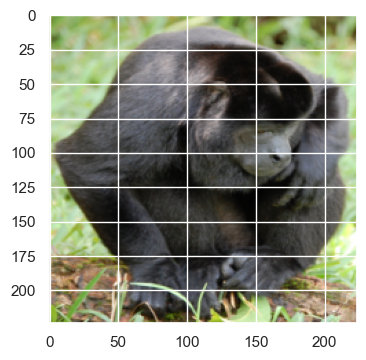

In [149]:
image = next(iter(monkeys_train_dataloader))[0][4]
plt.imshow(torch.clip(image.permute(1, 2, 0), 0, 1).cpu())

In [ ]:
torch.manual_seed(0)
net.eval()

fig = plt.figure(figsize=(10, 11))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, true_label = test_data[sample_idx]

    pred = net(img.unsqueeze(0).to(DEVICE))
    pred_proba = F.softmax(pred, 1).max(1).values.item()
    pred_label = pred.argmax(1).item()

    fig.add_subplot(rows, cols, i)
    plt.title(
        f"pred: {train_data.classes[pred_label]} ({pred_proba:.2f})"
        f"\ntrue: {train_data.classes[true_label]}", loc="left"
    )
    plt.axis("off")
    # 3 x 32 x 32 [-1, 1] -> 32 x 32 x 3 [0, 1]
    plt.imshow(torch.clip(img.permute(1, 2, 0), 0, 1).cpu())

In [ ]:
X_test, y_test = next(iter(monkeys_test_dataloader))
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

pred = net(X_test)
pred_proba = torch.max(F.softmax(pred, dim=1), dim=1)
y_pred = pred.argmax(dim=1).detach()

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test.cpu(), y_pred.cpu(),
    display_labels=train_data.classes,
    xticks_rotation=45,
    cmap=sns.color_palette("light:b", as_cmap=True),
    colorbar=False,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(4.5, 4.5)

In [ ]:
print(metrics.classification_report(y_test.cpu(), y_pred.cpu(), target_names=train_data.classes))

In [ ]:
torch.save(net, MODELS_DIR / "Monkeys-cnn.pth")

In [51]:
!zip -r / content / models.zip / content / models

  adding: content/models/ (stored 0%)
  adding: content/models/FashionMNIST-log-reg.pth (deflated 8%)
  adding: content/models/CIFAR10-log-reg.pth (deflated 8%)


In [52]:
from google.colab import files

files.download("/content/models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [ ]:
!zip -r / content / models.zip / content / models

In [ ]:
from google.colab import files

files.download("/content/models.zip")

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)